In [1]:
## Importing Libraries

In [2]:
!pip install --upgrade networkx[default]
!pip install --upgrade scipy
!pip install pathpy
!pip install pyvis
!pip install python-louvain
!pip install community
!pip install decorator==5.0.9

In [3]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathpy as pp
import time
from datetime import datetime
from community import community_louvain
from pyvis.network import Network
import seaborn as sns
from pandas.api.types import CategoricalDtype

### 1. DATA PREPARATION

In [ ]:
# Function to read txt file and filter data in 2015
def prepare_df(file,type_,low,high):
    df=pd.read_fwf(file,encoding='utf-8',header=None)
    row_list = []
    for index,row in df[low:high].iterrows():
        row_i = row[0].split(" ")
        row_list.append(row_i)
    df = pd.DataFrame(row_list,columns=['source','target','time'])
    df['time']=pd.to_datetime(df['time'],unit='s')
    df = df.sort_values('time',ascending=False).reset_index()
    cond = (df['time']>='2014-12-01') & (df['time']<='2015-12-31')
    df = df[cond]
    df = df.drop('index',axis=1)
    df['type']=type_
    return df

In [ ]:
# Since data is so large, we only filter data in 2015 for our analysis
a2q_df = prepare_df('sx-stackoverflow-a2q.txt','a2q',-5000000,-500000)
print(a2q_df['time'].max())
print(a2q_df['time'].min())
print(len(a2q_df))
a2q_df.head()

In [ ]:
# Since data is so large, we only filter data in 2015 for our analysis
c2q_df = prepare_df('sx-stackoverflow-c2q.txt','c2q',-5000000,-1)
print(c2q_df['time'].max())
print(c2q_df['time'].min())
print(len(c2q_df))
c2q_df.head()

In [ ]:
# # Since data is so large, we only filter data in 2015 for our analysis
c2a_df = prepare_df('sx-stackoverflow-c2a.txt','c2a',-10000000,-1)
print(c2a_df['time'].max())
print(c2a_df['time'].min())
print(len(c2a_df))
c2a_df.head()

In [ ]:
# Filter data in 2015
cond_t = (c2a_df['time']>='2015-01-01') & (c2a_df['time']<='2015-12-31')
c2a_df = c2a_df[cond_t]
print(c2a_df['time'].max())
print(c2a_df['time'].min())
print(len(c2a_df))

In [12]:
## After filtering the data, the data is being stored in csv files for easy accessibility. 

In [ ]:
#Export data created above into csv
a2q_df.to_csv("a2q_df.csv")
c2q_df.to_csv("c2q_df.csv")
c2a_df.to_csv("c2a_df.csv")

In [4]:
# Read data set in 2015
a2q_df = pd.read_csv("a2q_df.csv",index_col=0).reset_index(drop=True)
c2q_df = pd.read_csv("c2q_df.csv",index_col=0).reset_index(drop=True)
c2a_df = pd.read_csv("c2a_df.csv",index_col=0).reset_index(drop=True)

In [6]:
# Format column "time" to yyyy-mm-dd
a2q_df['yr_m_d'] = pd.to_datetime(a2q_df['time'])
a2q_df['yr_m_d'] = a2q_df['yr_m_d'].dt.normalize()
a2q_df.head()

,source,target,time,type,yr_m_d
0,5293521,72,2015-12-30 22:48:29,a2q,2015-12-30
1,6722,106,2015-12-30 20:57:57,a2q,2015-12-30
2,476,449227,2015-12-30 18:42:06,a2q,2015-12-30
3,4376,4376,2015-12-30 18:29:18,a2q,2015-12-30
4,90263,5454,2015-12-30 18:26:01,a2q,2015-12-30


In [8]:
# Format column "time" to yyyy-mm-dd
c2q_df['yr_m_d'] = pd.to_datetime(c2q_df['time'])
c2q_df['yr_m_d'] = c2q_df['yr_m_d'].dt.normalize()
c2q_df.head()

,source,target,time,type,yr_m_d
0,2169261,4230863,2015-12-30 23:59:45,c2q,2015-12-30
1,4577762,4230863,2015-12-30 23:59:39,c2q,2015-12-30
2,29407,3140169,2015-12-30 23:59:39,c2q,2015-12-30
3,3959259,4230863,2015-12-30 23:59:37,c2q,2015-12-30
4,2170070,4921328,2015-12-30 23:59:33,c2q,2015-12-30


In [9]:
# Format column "time" to yyyy-mm-dd
c2a_df['yr_m_d'] = pd.to_datetime(c2a_df['time'])
c2a_df['yr_m_d'] = c2a_df['yr_m_d'].dt.normalize()
c2a_df.head()

,source,target,time,type,yr_m_d
0,40521,40521,2015-12-30 23:59:59,c2a,2015-12-30
1,41316,41316,2015-12-30 23:59:37,c2a,2015-12-30
2,521757,88656,2015-12-30 23:58:16,c2a,2015-12-30
3,29407,29407,2015-12-30 23:57:35,c2a,2015-12-30
4,2404470,6884,2015-12-30 23:55:03,c2a,2015-12-30


In [10]:
# Add day name into the data set
a2q_df['day_name'] = a2q_df['yr_m_d'].dt.strftime('%A')
c2a_df['day_name'] = c2a_df['yr_m_d'].dt.strftime('%A')
c2q_df['day_name'] = c2q_df['yr_m_d'].dt.strftime('%A')

In [11]:
# Convert day name to a desired order
weekday = CategoricalDtype(['Monday', 'Tuesday', 'Wednesday', 
                            'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
a2q_df['day_name'] = a2q_df['day_name'].astype(weekday)
c2a_df['day_name'] = c2a_df['day_name'].astype(weekday)
c2q_df['day_name'] = c2q_df['day_name'].astype(weekday)

### 2. EXPLORATORY DATA ANALYSIS

In [5]:
print(a2q_df.shape)
print(c2q_df.shape)
print(c2a_df.shape)

(3070, 4)
(3955872, 4)
(191136, 4)


In [53]:
a2q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3070 entries, 0 to 3069
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   source    3070 non-null   int64         
 1   target    3070 non-null   int64         
 2   time      3070 non-null   object        
 3   type      3070 non-null   object        
 4   yr_m_d    3070 non-null   datetime64[ns]
 5   day_name  3070 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 123.4+ KB


In [54]:
c2q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955872 entries, 0 to 3955871
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   source    int64         
 1   target    int64         
 2   time      object        
 3   type      object        
 4   yr_m_d    datetime64[ns]
 5   day_name  category      
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 154.7+ MB


In [55]:
c2a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191136 entries, 0 to 191135
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   source    191136 non-null  int64         
 1   target    191136 non-null  int64         
 2   time      191136 non-null  object        
 3   type      191136 non-null  object        
 4   yr_m_d    191136 non-null  datetime64[ns]
 5   day_name  191136 non-null  category      
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 7.5+ MB


In [63]:
print('A2Q')
print(a2q_df.isnull().sum())
print(a2q_df.describe())
print('C2Q')
print(c2q_df.isnull().sum())
print(c2q_df.describe())
print('C2A')
print(c2a_df.isnull().sum())
print(c2a_df.describe())

A2Q
source      0
target      0
time        0
type        0
yr_m_d      0
day_name    0
dtype: int64
             source        target
count  3.070000e+03  3.070000e+03
mean   2.659492e+05  3.559479e+05
std    8.030769e+05  1.025112e+06
min    1.000000e+00  1.000000e+00
25%    9.050000e+02  8.930000e+02
50%    6.776000e+03  6.265000e+03
75%    8.450700e+04  7.370450e+04
max    5.664815e+06  5.676234e+06
C2Q
source      0
target      0
time        0
type        0
yr_m_d      0
day_name    0
dtype: int64
             source        target
count  3.955872e+06  3.955872e+06
mean   2.509786e+06  3.375054e+06
std    1.706693e+06  1.685484e+06
min    3.000000e+00  1.000000e+00
25%    9.924840e+05  1.872194e+06
50%    2.291869e+06  3.773629e+06
75%    4.056231e+06  4.878175e+06
max    5.953725e+06  6.001408e+06
C2A
source      0
target      0
time        0
type        0
yr_m_d      0
day_name    0
dtype: int64
             source        target
count  1.911360e+05  1.911360e+05
mean   5.532910e+

In [13]:
#a2q
# Number of unique ID who asks questions
Unique_questionID = a2q_df['target'].nunique()
print("Number of unique ID who asks questions - a2q:",Unique_questionID)
# Number of unique ID who answers questions
Unique_answerID = a2q_df['source'].nunique()
print("Number of unique ID who answers questions - a2q:",Unique_answerID)

Number of unique ID who asks questions - a2q: 1891
Number of unique ID who answers questions - a2q: 1723


In [36]:
#c2q
# Number of unique ID who asks questions
Unique_questionID_c2q = c2q_df['target'].nunique()
print("Number of unique ID who asks questions - c2q:",Unique_questionID_c2q)
# Number of unique ID who comment on questions
Unique_commentsID = c2q_df['source'].nunique()
print("Number of unique ID who comment on questions - c2q:",Unique_commentsID)

Number of unique ID who asks questions - c2q: 531308
Number of unique ID who comment on questions - c2q: 431971


In [37]:
#c2a
# Number of unique ID who answers questions
Unique_answerID_c2a = c2a_df['target'].nunique()
print("Number of unique ID who give answers - c2a:",Unique_answerID_c2a)
# Number of unique ID who comments on answers
Unique_commentsID_c2a = c2a_df['source'].nunique()
print("Number of unique ID who comment on answers - c2a:",Unique_commentsID_c2a)

Number of unique ID who give answers - c2a: 29395
Number of unique ID who comment on answers - c2a: 44363


C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(a2q_df.corr())
C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(c2q_df.corr())
C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(c2a_df.corr())
C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:5: FutureWarnin

          source    target
source  1.000000 -0.114818
target -0.114818  1.000000
          source    target
source  1.000000  0.378912
target  0.378912  1.000000
          source    target
source  1.000000 -0.156654
target -0.156654  1.000000


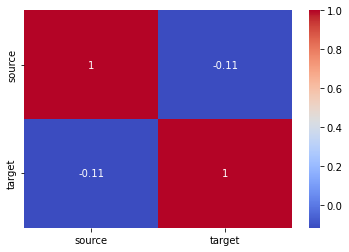

C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(c2q_df.corr(), annot=True, cmap='coolwarm')


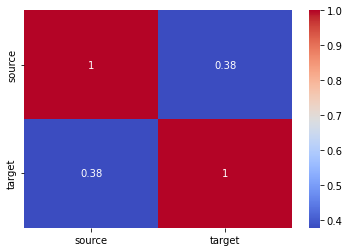

C:\Users\saksh\AppData\Local\Temp\ipykernel_16068\3370433095.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(c2a_df.corr(), annot=True, cmap='coolwarm')


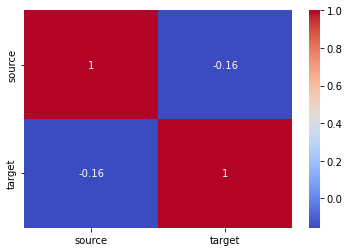

In [66]:
print(a2q_df.corr())
print(c2q_df.corr())
print(c2a_df.corr())

sns.heatmap(a2q_df.corr(), annot=True, cmap='coolwarm')
plt.show()

sns.heatmap(c2q_df.corr(), annot=True, cmap='coolwarm')
plt.show()

sns.heatmap(c2a_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [67]:
#The correlation results suggest a weak relationship between the number of sources and targets in the dataframes.

### 3. DESCRIPTIVE ANALYSIS

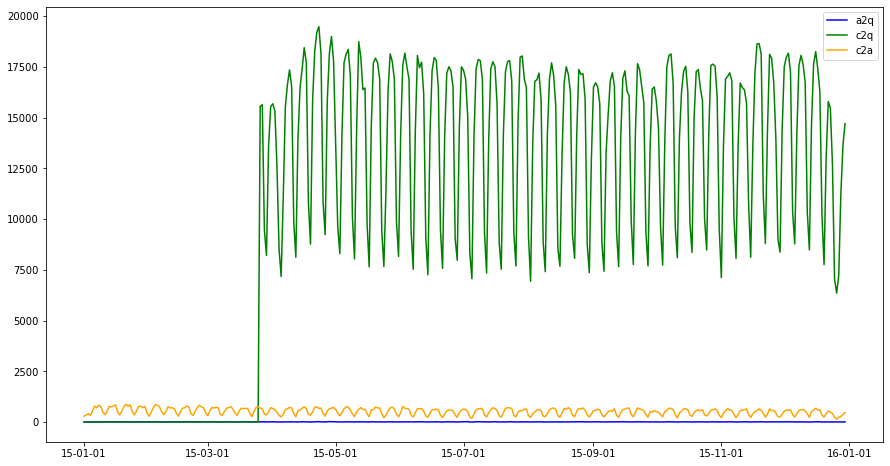

In [16]:
# Plot A2Q, C2Q, C2A interaction 
from matplotlib.dates import DateFormatter
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(a2q_df.groupby('yr_m_d')['source'].count(),label='a2q',color ='blue')
plt.plot(c2q_df.groupby('yr_m_d')['source'].count(),label='c2q',color ='green')
plt.plot(c2a_df.groupby('yr_m_d')['source'].count(),label='c2a',color ='orange')
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.legend()
plt.show()

In [17]:
# Users heavily make comments on questions(C2Q) > comments on answers(C2A) > answer to questions(A2Q)
# There are repeated patterns indicating that users are likely to respond certain days. 
# Plotting to show what day during a week people are active to respond.

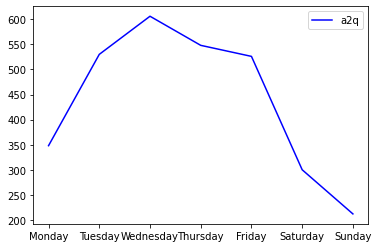

In [18]:
plt.plot(a2q_df.groupby(['day_name'])['source'].count(),label='a2q',color ='blue')
plt.legend()
plt.show()

In [21]:
# People are more active to answer on questions from Tue to Fri 

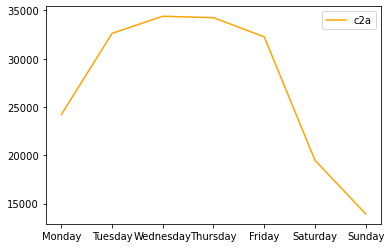

In [19]:
plt.plot(c2a_df.groupby(['day_name'])['source'].count(),label='c2a',color ='orange')
plt.legend()
plt.show()

In [22]:
# People are more active to comment on answers from Tue to Fri 

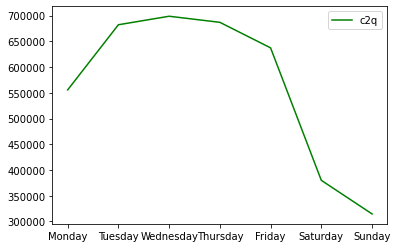

In [20]:
plt.plot(c2q_df.groupby(['day_name'])['source'].count(),label='c2q',color ='green')
plt.legend()
plt.show()

In [23]:
# People are more active to comment on questions from Tue to Fri 

### 4. NETWORK VISUALIZATION

In [24]:
# Create a network graph fuction. 
# Since the network graph takes a long time to run. Here, the network graph is in html format and is opening in another window.
def net_graph(df,range_,name):
    df = df[0:range_]
    net= Network(notebook = True, width="500px", height="500px", bgcolor='#222222', font_color='white',cdn_resources='remote')
    
    G = nx.from_pandas_edgelist(df,source='source',target='target',create_using=nx.Graph())
    
    node_degree = dict(G.degree)

    #Setting up node size attribute
    nx.set_node_attributes(G, node_degree, 'size')
    nx.set_node_attributes(G, node_degree, 'color')
    net.from_nx(G)
    net.show(name)

### 4.1. a2q analysis

### 4.1.1. a2q 2015 year, 2015-12-30 one day & one week

In [25]:
a2q_df.shape

(3070, 6)

In [26]:
# Create network graph for a2q during entire year 2015
net_graph(a2q_df,len(a2q_df),'a2q_df.html')

a2q_df.html


In [35]:
# Create network graph for one week 2015-12-30 to 2015-12-23 analysis
a2q_df_2015_12_30_wk = a2q_df[(a2q_df['yr_m_d']<='2015-12-30') & (a2q_df['yr_m_d']>='2015-12-23')]
net_graph(a2q_df_2015_12_30_wk,len(a2q_df_2015_12_30_wk),'a2q_df_2015_12_30_wk.html')

a2q_df_2015_12_30_wk.html


In [34]:
# Create network graph for one day 2015-12-30 analysis
a2q_df_2015_23_30 = a2q_df[a2q_df['yr_m_d']=='2015-12-30']
net_graph(a2q_df_2015_23_30,len(a2q_df_2015_23_30),'a2q_df_2015_23_30.html')

a2q_df_2015_23_30.html


### 4.1.2. Network Analysis of 1 year A2Q

In [27]:
# Run the network graph manually here to extract important key metrics
net_a2q_df = Network(notebook = True, width="500px", height="500px", bgcolor='#222222', font_color='white',cdn_resources='remote')

G_a2q_df = nx.from_pandas_edgelist(a2q_df,source='source',target='target',create_using=nx.Graph())

node_degree_a2q_df = dict(G_a2q_df.degree)

# Key metrics, degree centrality, betweenness centrality, closeness centrality, eigenvector centrality
degree_dict_a2q_df = nx.degree_centrality(G_a2q_df)
betweenness_dict_a2q_df = nx.betweenness_centrality(G_a2q_df)
closeness_dict_a2q_df = nx.closeness_centrality(G_a2q_df)
eigenvector_centrality_a2q_df = nx.eigenvector_centrality(G_a2q_df,max_iter=600)
edge_betweenness_centrality_a2q_df = nx.edge_betweenness_centrality(G_a2q_df)

In [28]:
print(f'Number of edges of a2q: {len(G_a2q_df.edges())}')
print(f'Number of nodes of a2q: {len(G_a2q_df.nodes())}')

Number of edges of a2q: 2736
Number of nodes of a2q: 3121


In [29]:
# Creat bar plot
def bar_plot(dict_,type_,name):
    dict_df = pd.DataFrame.from_dict(dict_,orient='index',columns=[name])
    dict_df.sort_values(name,ascending=False)[0:20].plot(kind='bar')
    plt.title(f'{name} of {type_}')

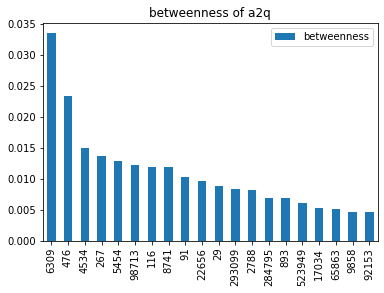

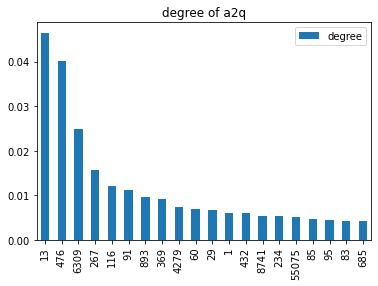

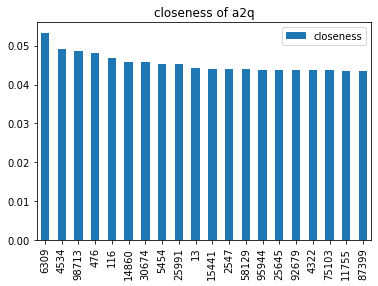

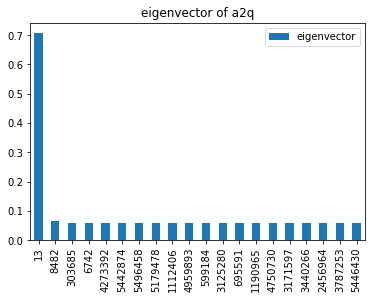

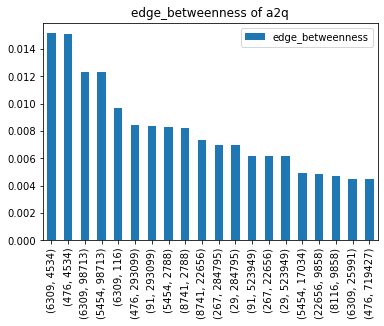

In [38]:
# Generate bar plots
bar_plot(betweenness_dict_a2q_df, 'a2q', 'betweenness')
bar_plot(degree_dict_a2q_df, 'a2q', 'degree')

# Nodes with a high closeness score have the shortest distances to all other nodes.
# formular ref = https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html
bar_plot(closeness_dict_a2q_df, 'a2q', 'closeness')

bar_plot(eigenvector_centrality_a2q_df, 'a2q', 'eigenvector')

bar_plot(edge_betweenness_centrality_a2q_df, 'a2q', 'edge_betweenness')

### 4.2. c2a analysis

In [39]:
c2a_df.shape

(191136, 6)

In [40]:
# Create network graph for c2a. It is for ref only. We will analyze metrics for ONE WEEK data
c2a_df_2015_23_30 = c2a_df[c2a_df['yr_m_d']=='2015-12-30']
#net_graph(c2a_df_2015_23_30,len(c2a_df_2015_23_30),'c2a_df_2015_23_30.html')

In [41]:
# Create network graph 
net_c2a_df_day = Network(notebook = True, width="500px", height="500px", bgcolor='#222222', font_color='white',cdn_resources='remote')

G_c2a_df_day = nx.from_pandas_edgelist(c2a_df_2015_23_30,source='source',target='target',create_using=nx.Graph())

# Set up degree attribute
node_degree_c2a_df_day = dict(G_c2a_df_day.degree)

# Compute important metrics
degree_dict_c2a_df_day = nx.degree_centrality(G_c2a_df_day)
betweenness_dict_c2a_df_day = nx.betweenness_centrality(G_c2a_df_day)
closeness_dict_c2a_df_day = nx.closeness_centrality(G_c2a_df_day)
eigenvector_centrality_c2a_df_day = nx.eigenvector_centrality(G_c2a_df_day,max_iter=600)
edge_betweenness_centrality_c2a_df_day = nx.edge_betweenness_centrality(G_c2a_df_day)

In [42]:
print(f'Number of edges of a2q: {len(G_c2a_df_day.edges())}')
print(f'Number of nodes of a2q: {len(G_c2a_df_day.nodes())}')

Number of edges of a2q: 323
Number of nodes of a2q: 459


In [43]:
# Create network graph one week 2015-12-30 to 2015-12-23 analysis
c2a_df_2015_23_30_wk = c2a_df[(c2a_df['yr_m_d']<='2015-12-30') & (c2a_df['yr_m_d']>='2015-12-23')]
#net_graph(c2a_df_2015_23_30_wk,len(c2a_df_2015_23_30_wk),'c2a_df_2015_23_30_wk.html')

In [44]:
# Create network graph 
net_c2a_df_wk = Network(notebook = True, width="500px", height="500px", bgcolor='#222222', font_color='white',cdn_resources='remote')

G_c2a_df_wk = nx.from_pandas_edgelist(c2a_df_2015_23_30_wk,source='source',target='target',create_using=nx.Graph())

# Set up degree attribute
node_degree_c2a_df_wk = dict(G_c2a_df_wk.degree)

# Compute important metrics
degree_dict_c2a_df_wk = nx.degree_centrality(G_c2a_df_wk)
betweenness_dict_c2a_df_wk = nx.betweenness_centrality(G_c2a_df_wk)
closeness_dict_c2a_df_wk = nx.closeness_centrality(G_c2a_df_wk)
eigenvector_centrality_c2a_df_wk = nx.eigenvector_centrality(G_c2a_df_wk,max_iter=600)
edge_betweenness_centrality_c2a_df_wk = nx.edge_betweenness_centrality(G_c2a_df_wk)

In [45]:
print(f'Number of edges of a2q: {len(G_c2a_df_wk.edges())}')
print(f'Number of nodes of a2q: {len(G_c2a_df_wk.nodes())}')

Number of edges of a2q: 1634
Number of nodes of a2q: 2118


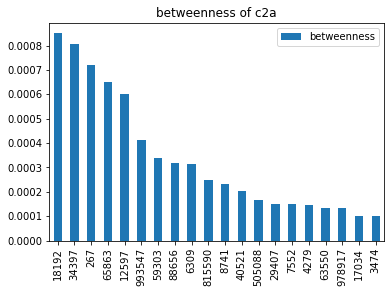

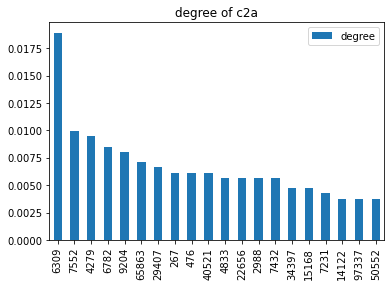

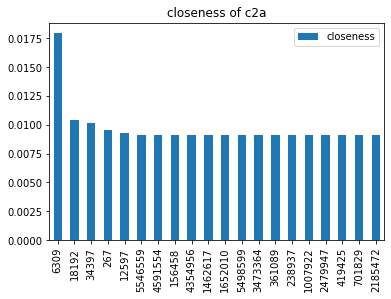

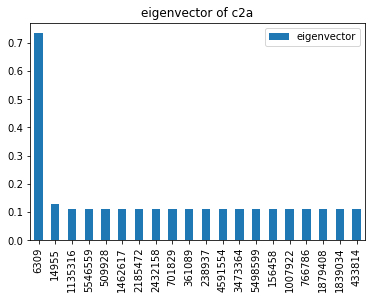

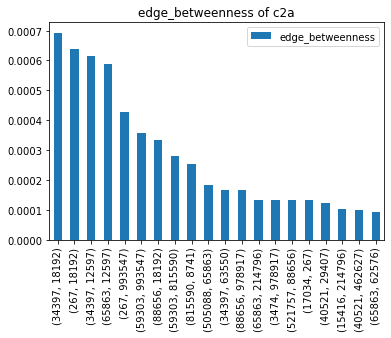

In [46]:
# Create bar plot for metrics and community
bar_plot(betweenness_dict_c2a_df_wk, 'c2a', 'betweenness')
bar_plot(degree_dict_c2a_df_wk, 'c2a', 'degree')
bar_plot(closeness_dict_c2a_df_wk, 'c2a', 'closeness')
bar_plot(eigenvector_centrality_c2a_df_wk, 'c2a', 'eigenvector')
bar_plot(edge_betweenness_centrality_c2a_df_wk, 'c2a', 'edge_betweenness')

### 4.3. c2q analysis 

In [47]:
c2q_df.shape

(3955872, 6)

In [48]:
# Data is so huge, so we just show network analysis on 1 day
c2q_df_2015_23_30 = c2q_df[c2q_df['yr_m_d']=='2015-12-30']

In [49]:
# Create network graph
net_graph(c2q_df_2015_23_30,len(c2q_df_2015_23_30),'c2q_df_2015_23_30.html')

c2q_df_2015_23_30.html


In [50]:
# Create network graph
net_c2q_df_day = Network(notebook = True, width="500px", height="500px", bgcolor='#222222', font_color='white',cdn_resources='remote')

G_c2q_df_day = nx.from_pandas_edgelist(c2q_df_2015_23_30,source='source',target='target',create_using=nx.Graph())

# Store network degree in a dictionary
node_degree_c2q_df_day = dict(G_c2q_df_day.degree)

# Compute important key metrics 
degree_dict_c2q_df_day = nx.degree_centrality(G_c2q_df_day)
betweenness_dict_c2q_df_day = nx.betweenness_centrality(G_c2q_df_day)
closeness_dict_c2q_df_day = nx.closeness_centrality(G_c2q_df_day)
eigenvector_centrality_c2a_df_day = nx.eigenvector_centrality(G_c2q_df_day,max_iter=600)
edge_betweenness_centrality_c2a_df_day = nx.edge_betweenness_centrality(G_c2q_df_day)

In [51]:
print(f'Number of edges of a2q: {len(G_c2q_df_day.edges())}')
print(f'Number of nodes of a2q: {len(G_c2q_df_day.nodes())}')

Number of edges of a2q: 10287
Number of nodes of a2q: 8631


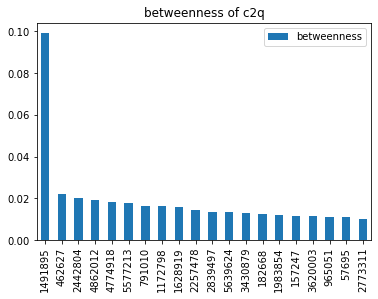

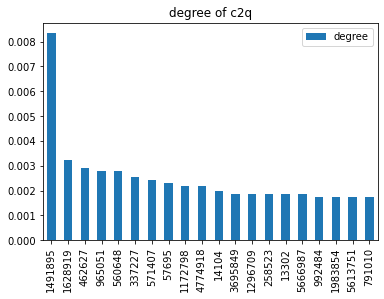

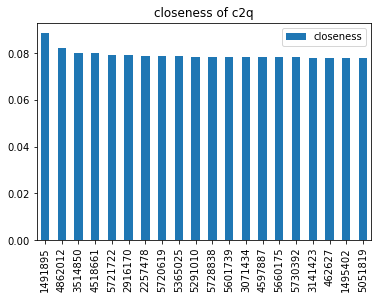

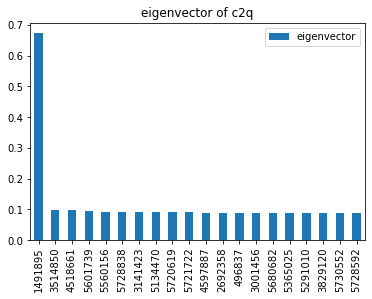

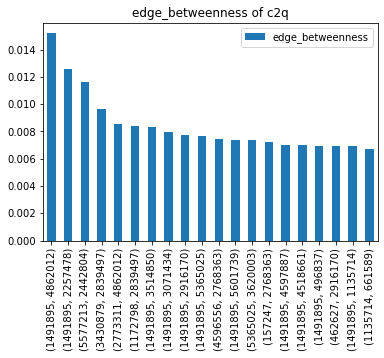

In [52]:
# Create bar plot
bar_plot(betweenness_dict_c2q_df_day, 'c2q', 'betweenness')
bar_plot(degree_dict_c2q_df_day, 'c2q', 'degree')
bar_plot(closeness_dict_c2q_df_day, 'c2q', 'closeness')
bar_plot(eigenvector_centrality_c2a_df_day, 'c2q', 'eigenvector')
bar_plot(edge_betweenness_centrality_c2a_df_day, 'c2q', 'edge_betweenness')

# 4. Visualize community 

ref: https://networkx.org/documentation/stable/reference/algorithms/community.html

### 4.1. Creating Communities

In [69]:
# Function to create communities and set color to each community
def com_graph(df,range_,name):
    df = df[0:range_]
    
    com_net = Network(notebook=True, width="500px", height="500px",bgcolor='#222222', font_color='white',cdn_resources='remote')
    G = nx.from_pandas_edgelist(df,source='source',target='target',create_using=nx.Graph())
    communities = community_louvain.best_partition(G,resolution=30)
    node_degree = dict(G.degree)

    #Setting up node size, color attribute
    nx.set_node_attributes(G, node_degree, 'size')
    nx.set_node_attributes(G, communities, 'group')

    com_net.from_nx(G)
    com_net.show(name)

In [70]:
# Create communities graph for a2q all year 2015
com_graph(a2q_df,len(a2q_df),'a2q_df_com_2.html')

a2q_df_com_2.html


In [71]:
# Create communities graph for a2q one week
com_graph(a2q_df_2015_12_30_wk,len(a2q_df_2015_12_30_wk),'a2q_df_2015_12_30_wk_com.html')

a2q_df_2015_12_30_wk_com.html


In [72]:
# Create communities graph for a2q one day
com_graph(a2q_df_2015_23_30,len(a2q_df_2015_23_30),'a2q_df_2015_23_30_com.html')

a2q_df_2015_23_30_com.html


In [73]:
# Create communities graph for c2a one week
com_graph(c2a_df_2015_23_30_wk,len(c2a_df_2015_23_30_wk),'c2a_df_2015_23_30_wk_com.html')

c2a_df_2015_23_30_wk_com.html


In [74]:
# Create communities graph for c2a one day
com_graph(c2a_df_2015_23_30,len(c2a_df_2015_23_30),'c2a_df_2015_23_30_com.html')

c2a_df_2015_23_30_com.html


In [75]:
# Create communities graph for c2q one day
com_graph(c2q_df_2015_23_30,len(c2q_df_2015_23_30),'c2q_df_2015_23_30_com.html')

c2q_df_2015_23_30_com.html


### 4.2. Creating community plots

In [78]:
# Group users into communities
def community_plot(communities, type_):
    communities_group_label = set(communities.values())
    communities_group_list = list(communities.values())
    
    communities_group_label_count = []
    for element in communities_group_label:
        element_count = communities_group_list.count(element)
        communities_group_label_count.append(element_count)
    
    communities_df = pd.DataFrame(columns=list(communities_group_label))
    communities_df.loc[0,:] = communities_group_label_count
    communities_df = communities_df.T
    communities_df = communities_df.rename({0:'community_population'},axis=1)
    communities_df.sort_values('community_population',ascending=False)[0:20].plot(kind='bar',color='green')
    
    plt.title(f'Community population {type_}')
    plt.show()

### 4.2.1. a2q

In [ ]:
# Create cluster based on community louvain algorithm
# ref https://networkx.org/documentation/stable/reference/algorithms/community.html
communities_a2q_df = community_louvain.best_partition(G_a2q_df)

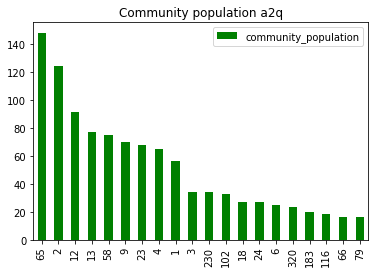

In [84]:
community_plot(communities_a2q_df, 'a2q')

### 4.2.2. c2a

In [79]:
# Run community algorithm
communities_c2a_df_wk = community_louvain.best_partition(G_c2a_df_wk)

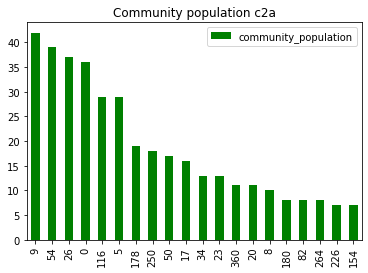

In [80]:
community_plot(communities_c2a_df_wk, 'c2a')

### 4.2.3. c2q

In [82]:
# Run community algorithm
communities_c2q_df_day = community_louvain.best_partition(G_c2q_df_day)

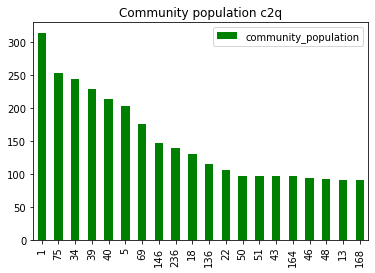

In [83]:
community_plot(communities_c2q_df_day,'c2q')